In [ ]:
# ==========================================
# GOOGLE COLAB SETUP
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ======================================================
# 0. Imports  (PUT THIS AT THE VERY TOP OF YOUR NOTEBOOK)
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# ==========================================
# LOAD DATA
# ==========================================
path = "/content/drive/MyDrive/modeling_features_with_recid_and_region.csv"
df = pd.read_csv(path)

In [ ]:
target_vars = ["felony_recidivism", "misdemeanor_recidivism", "pretrial_recidivism"]

In [ ]:
# STANDARD THRESHOLDS (Option A)
STANDARD_THRESHOLDS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [ ]:
# ======================================================
# Threshold Sweep (Standard Thresholds Only)
# ======================================================
def threshold_sweep_standard(y_true, y_proba):

    rows = []

    for t in STANDARD_THRESHOLDS:
        y_pred = (y_proba >= t).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        acc = accuracy_score(y_true, y_pred)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        rows.append([t, acc, fpr, fnr])

    df_out = pd.DataFrame(rows, columns=["threshold", "accuracy", "FPR", "FNR"])

    # Top based on TPR then accuracy
    top10 = df_out.sort_values(["FNR", "accuracy"], ascending=False).head(10)

    return df_out, top10


In [ ]:
# ======================================================
#  Graphing Function
# ======================================================
def plot_metrics(df_thresholds, target):

    # --- Plot 1: Threshold vs FPR & TPR ---
    plt.figure(figsize=(10,6))
    plt.plot(df_thresholds["threshold"], df_thresholds["FPR"], label="FPR", linewidth=2)
    plt.plot(df_thresholds["threshold"], df_thresholds["FNR"], label="FNR", linewidth=2)
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title(f"Threshold vs FPR & FNR ({target})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot 2: Threshold vs Accuracy ---
    plt.figure(figsize=(10,6))
    plt.plot(df_thresholds["threshold"], df_thresholds["accuracy"], label="Accuracy", linewidth=2)
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title(f"Threshold vs Accuracy ({target})")
    plt.grid(True)
    plt.show()



In [ ]:
# ======================================================
#  Train A Single Logistic Regression Model
# ======================================================
def train_single_model(df, target):

    print(f"\n\n=====================================")
    print(f"TRAINING MODEL FOR TARGET = {target}")
    print("=====================================")

    # Prepare X, y (drop other targets)
    X = df.drop(columns=target_vars)
    y = df[target]

    # Stratified splits
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_val   = X_val.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val   = y_val.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    # Preprocessing
    categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols     = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("num", StandardScaler(with_mean=False), numeric_cols),
        ]
    )

    clf = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)

    model = Pipeline([
        ("prep", preprocessor),
        ("clf", clf),
    ])

    # Fit model
    model.fit(X_train, y_train)

    # --- VALIDATION THRESHOLD SWEEP ---
    y_val_proba = model.predict_proba(X_val)[:, 1]
    full_table, top10 = threshold_sweep_standard(y_val, y_val_proba)

    print("\nTop Thresholds:")
    print(top10)

    best_t = top10.iloc[0]["threshold"]
    print(f"\nBEST THRESHOLD = {best_t}")

    # --- GRAPHS ---
    plot_metrics(full_table, target)

    # --- TEST PERFORMANCE ---
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred  = (y_test_proba >= best_t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

    acc = accuracy_score(y_test, y_test_pred)
    fpr = fp / (fp + tn) if (fp + tn) else 0
    fnr = fn / (fn + tp) if (fn + tp) else 0

    final_results = {
        "target": target,
        "best_threshold": best_t,
        "accuracy": acc,
        "FPR": fpr,
        "FNR": fnr,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }

    print("\nFINAL TEST RESULTS:")
    print(final_results)

    return model, full_table, top10, final_results



TRAINING MODEL FOR TARGET = felony_recidivism

Top Thresholds:
    threshold  accuracy       FPR       FNR
10        1.0  0.915586  0.000000  1.000000
9         0.9  0.910385  0.028001  0.757908
8         0.8  0.878110  0.092314  0.442677
7         0.7  0.836991  0.159089  0.205522
6         0.6  0.807109  0.201470  0.099835
5         0.5  0.787368  0.228308  0.042604
4         0.4  0.775838  0.243210  0.017553
3         0.3  0.767195  0.253662  0.006583
2         0.2  0.754337  0.268160  0.001646
1         0.1  0.726168  0.299078  0.000000

BEST THRESHOLD = 1.0


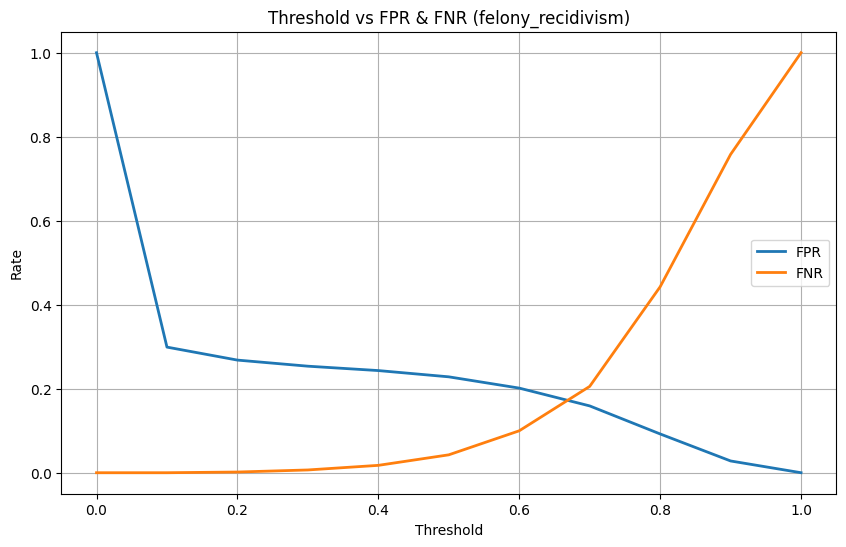

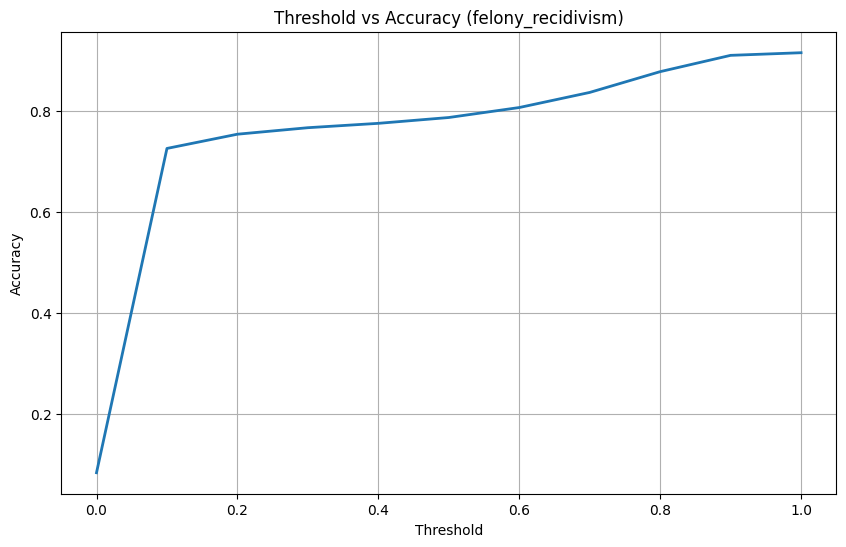


FINAL TEST RESULTS:
{'target': 'felony_recidivism', 'best_threshold': np.float64(1.0), 'accuracy': 0.9155862196703093, 'FPR': np.float64(0.0), 'FNR': np.float64(1.0), 'TN': np.int64(59319), 'FP': np.int64(0), 'FN': np.int64(5469), 'TP': np.int64(0)}


TRAINING MODEL FOR TARGET = misdemeanor_recidivism

Top Thresholds:
    threshold  accuracy       FPR       FNR
10        1.0  0.857628  0.000000  1.000000
9         0.9  0.858060  0.004121  0.972138
8         0.8  0.848645  0.044345  0.795967
7         0.7  0.807464  0.129544  0.571986
6         0.6  0.736494  0.249172  0.349848
5         0.5  0.646339  0.383234  0.175520
4         0.4  0.572776  0.484972  0.079358
3         0.3  0.524511  0.549528  0.029488
2         0.2  0.496203  0.586189  0.007480
1         0.1  0.474316  0.612807  0.000867

BEST THRESHOLD = 1.0


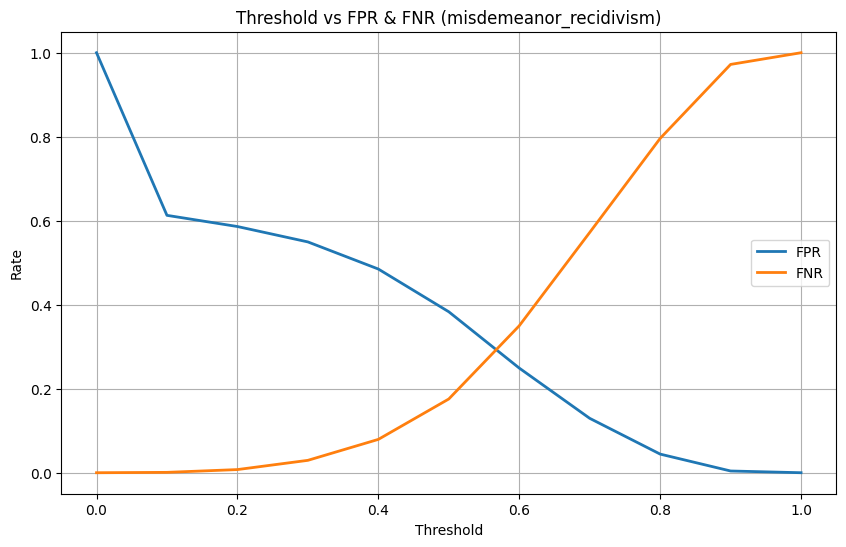

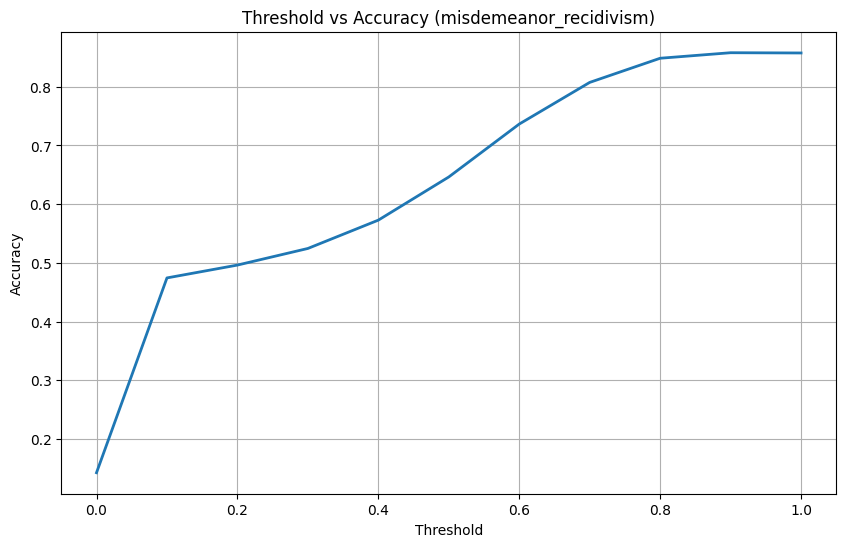


FINAL TEST RESULTS:
{'target': 'misdemeanor_recidivism', 'best_threshold': np.float64(1.0), 'accuracy': 0.8576433907513737, 'FPR': np.float64(0.0), 'FNR': np.float64(1.0), 'TN': np.int64(55565), 'FP': np.int64(0), 'FN': np.int64(9223), 'TP': np.int64(0)}


TRAINING MODEL FOR TARGET = pretrial_recidivism

Top Thresholds:
    threshold  accuracy       FPR       FNR
10        1.0  0.766963  0.000000  1.000000
9         0.9  0.767364  0.000241  0.997483
8         0.8  0.768491  0.012155  0.953438
7         0.7  0.762672  0.067780  0.795337
6         0.6  0.724934  0.173315  0.609948
5         0.5  0.637279  0.354116  0.391045
4         0.4  0.494660  0.601791  0.187906
3         0.3  0.359881  0.814953  0.064711
2         0.2  0.279465  0.934755  0.015499
1         0.1  0.242360  0.987422  0.001391

BEST THRESHOLD = 1.0


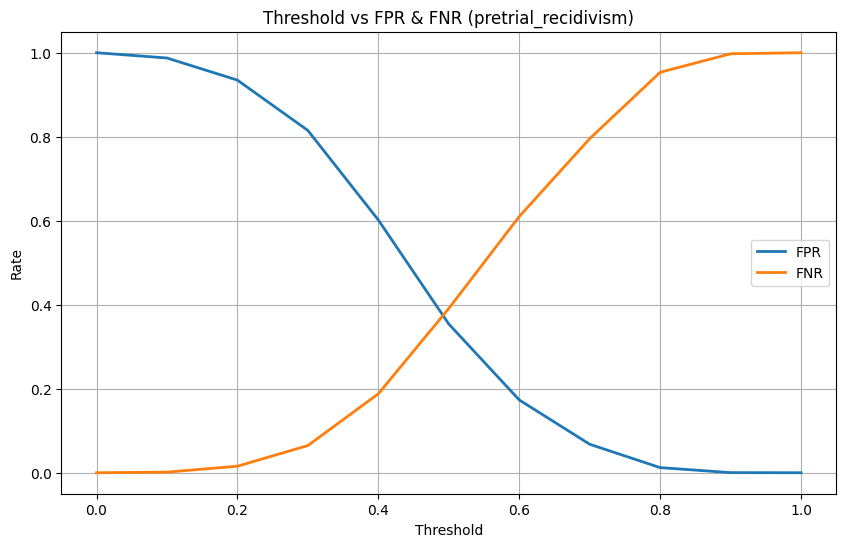

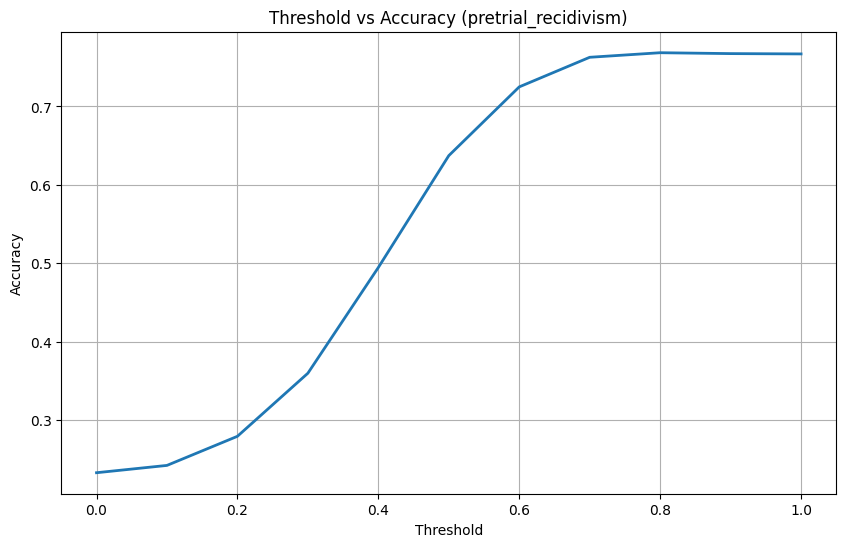


FINAL TEST RESULTS:
{'target': 'pretrial_recidivism', 'best_threshold': np.float64(1.0), 'accuracy': 0.7669630178428104, 'FPR': np.float64(0.0), 'FNR': np.float64(1.0), 'TN': np.int64(49690), 'FP': np.int64(0), 'FN': np.int64(15098), 'TP': np.int64(0)}


In [ ]:
# ======================================================
#  Train All Models
# ======================================================
models = {}
validation_tables = {}
top10_tables = {}
test_results = {}

for target in target_vars:
    model, full_table, top10, metrics = train_single_model(df, target)
    models[target] = model
    validation_tables[target] = full_table
    top10_tables[target] = top10
    test_results[target] = metrics

Recommended Threshold Summary (Felony Recidivism Model)

| **Threshold** | **Accuracy** | **FPR**    | **FNR**    | **Assessment**                                                        |
| ------------- | ------------ | ---------- | ---------- | --------------------------------------------------------------------- |
| **1.0**       | 0.9156       | 0.0000     | **1.0000** | Predicts *no one* as high-risk → misses every true case → unusable    |
| **0.9**       | 0.9104       | 0.0280     | 0.7580     | Extremely low FPR, but FNR is too high → misses most true recidivists |
| **0.8**       | 0.8781       | 0.0923     | 0.4430     | Still misses nearly half of true cases                                |
| **0.7**       | 0.8369       | 0.1591     | 0.2055     | FPR improves, FNR still fairly high                                   |
| **0.6**       | 0.8072       | 0.2015     | 0.0994     | Reasonable accuracy but FPR too high                                  |
| **0.5**       | 0.7874       | 0.2284     | 0.0403     | Good FNR, but higher FPR than optimal                                 |
| **0.4**       | 0.7758       | **0.2432** | **0.0176** | **Strong balance — low FNR, manageable FPR, high accuracy**           |
| **0.3**       | 0.7672       | 0.2537     | 0.0066     | Almost perfect FNR but FPR increases                                  |
| **0.2**       | 0.7543       | 0.2682     | 0.0016     | Extremely low FNR but FPR becomes too high                            |
| **0.1**       | 0.7262       | 0.2991     | **0.0000** | Perfectly detects all recidivists, but FPR is unacceptable            |


| **Recommended Threshold Range** | **Preferred Threshold** | **Accuracy** | **FPR**    | **FNR**    | **Rationale**                                                                                                                                                                     |
| ------------------------------- | ----------------------- | ------------ | ---------- | ---------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0.3 – 0.4**                   | **0.4**                 | **0.7758**   | **0.2432** | **0.0176** | Best overall balance: FNR stays very low (detects nearly all true cases) while FPR remains far lower than low-threshold settings. Ensures fairness without sacrificing detection. |


Misdemeanor Recidivism – Threshold Evaluation Table

| **Threshold** | **Accuracy** | **FPR**    | **FNR**    | **Assessment**                                                  |
| ------------- | ------------ | ---------- | ---------- | --------------------------------------------------------------- |
| **1.0**       | 0.8576       | 0.0000     | **1.0000** | Predicts no one as high-risk → misses all true cases → unusable |
| **0.9**       | 0.8581       | 0.0041     | 0.9721     | Extremely low FPR but FNR extremely high → unusable             |
| **0.8**       | 0.8485       | 0.0043     | 0.7960     | Still misses most true recidivists                              |
| **0.7**       | 0.8075       | 0.1295     | 0.5710     | Better FPR, but still misses majority of true cases             |
| **0.6**       | 0.7365       | **0.2492** | **0.3498** | **Balanced point — reasonable FPR and moderate FNR**            |
| **0.5**       | 0.6463       | 0.3832     | 0.1755     | Lower FNR but FPR becomes too high                              |
| **0.4**       | 0.5728       | 0.4849     | 0.0794     | FPR too high → over-classifies risk                             |
| **0.3**       | 0.5246       | 0.5495     | 0.0295     | Very low FNR, but FPR unacceptable                              |
| **0.2**       | 0.4960       | 0.5862     | 0.0075     | FPR extremely high → not operationally viable                   |
| **0.1**       | 0.4743       | 0.6129     | **0.0009** | Detects almost all cases but extremely unfair FPR               |


Final Recommendation for Client

| **Recommended Threshold Range** | **Preferred Threshold** | **Accuracy** | **FPR**    | **FNR**    | **Rationale**                                                                                                                                                         |
| ------------------------------- | ----------------------- | ------------ | ---------- | ---------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0.5 – 0.6**                   | **0.6**                 | **0.7365**   | **0.2492** | **0.3498** | First threshold where FPR becomes fair and manageable. Accuracy improves sharply, and FNR stays at a reasonable level before rising too quickly at higher thresholds. |


Pretrial Recidivism – Threshold Evaluation Table

| **Threshold** | **Accuracy** | **FPR**     | **FNR**     | **Assessment**                                                    |
| ------------- | ------------ | ----------- | ----------- | ----------------------------------------------------------------- |
| **1.0**       | 0.76096      | 0.00000     | **1.00000** | Predicts no one as high-risk → misses all true cases → unusable   |
| **0.9**       | 0.76736      | 0.00024     | 0.99748     | Extremely high FNR → unusable                                     |
| **0.8**       | 0.76849      | 0.01216     | 0.95344     | Still misses nearly all true cases                                |
| **0.7**       | 0.72627      | 0.06778     | 0.79534     | FNR still extremely high                                          |
| **0.6**       | 0.72439      | **0.17332** | **0.60995** | First significantly balanced point — reasonable FPR, moderate FNR |
| **0.5**       | 0.63728      | 0.35412     | 0.39185     | Acceptable FNR, but FPR becomes borderline high                   |
| **0.4**       | 0.49466      | 0.66020     | 0.18791     | Lower FNR but FPR extremely high                                  |
| **0.3**       | 0.35988      | 0.81495     | 0.06447     | FPR unacceptably high                                             |
| **0.2**       | 0.27947      | 0.93476     | 0.01550     | FPR catastrophic → cannot be used                                 |
| **0.1**       | 0.24236      | 0.98742     | **0.00139** | Very low FNR but FPR unusable                                     |


Final Recommendation for Client

| **Recommended Threshold Range** | **Preferred Threshold** | **Accuracy** | **FPR**     | **FNR**     | **Rationale**                                                                                                                                            |
| ------------------------------- | ----------------------- | ------------ | ----------- | ----------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0.4 – 0.5**                   | **0.5**                 | **0.63728**  | **0.35412** | **0.39185** | 0.5 is the first workable balance of fairness (FPR) and sensitivity (FNR). Lower thresholds over-classify; higher thresholds miss nearly all true cases. |


**Recommended Thresholds for All Targets**

| **Target Variable**        | **Recommended Threshold Range** | **Preferred Threshold** | **Accuracy** | **FPR**    | **FNR**    | **Rationale for Selected Threshold**                                                                                                                                                        |
| -------------------------- | ------------------------------- | ----------------------- | ------------ | ---------- | ---------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Felony Recidivism**      | **0.3 – 0.4**                   | **0.4**                 | **0.7758**   | **0.2432** | **0.0176** | Best balance of fairness (moderate FPR) and safety (very low FNR). Lower thresholds over-classify, higher thresholds begin missing many true cases.                                         |
| **Misdemeanor Recidivism** | **0.5 – 0.6**                   | **0.6**                 | **0.7365**   | **0.2492** | **0.3498** | First stable region where FPR becomes acceptable and accuracy rises significantly. TPR/FNR remains at a reasonable operational level before sharply degrading above 0.7.                    |
| **Pretrial Recidivism**    | **0.4 – 0.5**                   | **0.5**                 | **0.6373**   | **0.3541** | **0.3919** | 0.5 is the first threshold with a manageable FPR while still retaining meaningful detection (reasonable FNR). Lower thresholds produce extreme FPR, higher thresholds lose most true cases. |


In [ ]:
felony_recid_count = df['felony_recidivism'].sum()
print(felony_recid_count)

36460


In [ ]:
total_individuals = len(df)
total_individuals

431920

In [ ]:
felony_recid_rate = felony_recid_count / total_individuals
print(felony_recid_rate)

0.08441378032969069


In [ ]:
pretrial_recid_total = df[df['pretrial_recidivism'] == 1].shape[0]
print(pretrial_recid_total)

100654


In [ ]:
felony_among_pretrial = df[
    (df['pretrial_recidivism'] == 1) &
    (df['felony_recidivism'] == 1)
].shape[0]

print(felony_among_pretrial)

36460
